In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import functools as ft
import jax.nn as jnn
from typing import Any
from typing import List
import sys
from AE_equinox import *
import numpy as np
import matplotlib.pyplot as plt
from VAE_IWAE import *

In [2]:
# Flax doesn't have its own data loading functions - we'll be using PyTorch dataloaders
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [8]:
from functools import partial
import jax
import jax.numpy as jnp

# 0) Keep train_images exactly as-is (0..255). No normalization.
# train_VAE will flatten if needed, so you don't have to.

# 1) Pick sigma_x to match the pixel scale (std across the dataset)
sigma_x = float(jnp.std(jnp.asarray(train_images, dtype=jnp.float32)))  # e.g., ~50–80 for MNIST-like

# 2) Build model
key_model = jax.random.PRNGKey(0)
model = DeepVAE(
    key_model,
    latent_dim=2,
    input_dim=784,
    encoder_hidden=(256, 128, 64, 32, 16, 8)
)

# 3) Configure the Gaussian ELBO loss (no IWAE, no weight decay)
loss_fn = partial(
    loss2_VAE,
    iwae=False,
    likelihood="gaussian",
    sigma_x=sigma_x,   # <-- the key bit
    beta=1.0,
    alpha=0.0
)

# 4) Train (use a different key than model init)
key_train = jax.random.PRNGKey(1)
trained_VAE = train_VAE(
    model=model,
    loss_fn=loss_fn,
    X=train_images,       # still 0..255
    steps=1000,
    batch_size=128,
    learning_rate=1e-4,
    print_every=1000,
    key=key_train,
    grad_clip=1.0         # recommended for stability with large scales
)


step=000000  loss=4592.9888
step=000999  loss=4403.3135


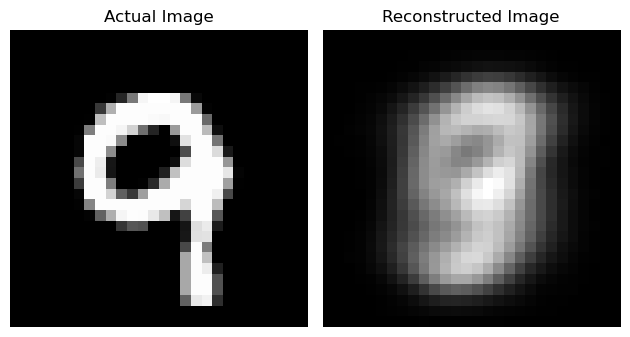

In [9]:
index = 99

encoded_image = trained_VAE.encode(test_images[index])[0]
decoded_image = trained_VAE.decode(encoded_image)

reconstructed_img = decoded_image.reshape(28, 28)
actual_img = test_images[index].reshape(28,28)

# Plot actual vs reconstructed
plt.subplot(1, 2, 1)
plt.imshow(actual_img, cmap='gray')
plt.title("Actual Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()



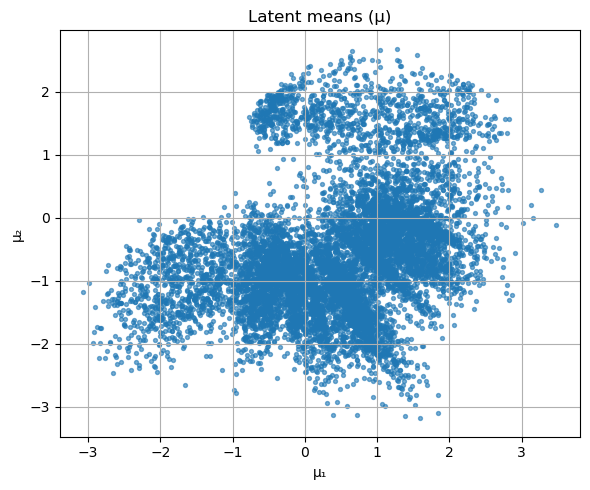

In [28]:
import matplotlib.pyplot as plt

mu, _ = jax.vmap(trained_VAE.encode)(test_images)   # (N, 2) if latent_dim=2
mu_np = jax.device_get(mu)

plt.figure(figsize=(6,5))
plt.scatter(mu_np[:, 0], mu_np[:, 1], s=8, alpha=0.6)
plt.xlabel("μ₁"); plt.ylabel("μ₂"); plt.title("Latent means (μ)")
plt.grid(True); plt.tight_layout(); plt.show()




In [3]:
decoded_image = trained_VAE.decode(jnp.array([-6,-6]))


reconstructed_img = decoded_image.reshape(28, 28)

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'trained_VAE' is not defined

In [ ]:
from functools import partial
import jax
import jax.numpy as jnp

# 0) Keep train_images exactly as-is (0..255). No normalization.

# 1) Match sigma_x to your data scale (keeps Gaussian NLL numerically sane)
sigma_x = float(jnp.std(jnp.asarray(train_images, dtype=jnp.float32)))  # ~50–80 for MNIST-like

# 2) Build model
key_model = jax.random.PRNGKey(0)
model = DeepVAE(
    key_model,
    latent_dim=2,
    input_dim=784,
    encoder_hidden=(256, 128, 64, 32, 16, 8)
)

# 3) Configure ELBO + Riemannian geometry regularizers
#    Start with one geometry term (MF uniformity) at a tiny weight.
#    geo_where="posterior", geo_at="mu": evaluate geometry at encoder means (stable, cheap).
#    geo_detach_z=True: only shape the decoder initially.
loss_fn = partial(
    loss2_VAE,
    iwae=False,                   # set True to use IWAE; geometry terms still apply
    likelihood="gaussian",
    sigma_x=sigma_x,
    beta=1.0,
    alpha=0.0,
    # ---- Riemannian geometry knobs ----
    lambda_mf=1e-6,               # MF uniformity (var(logdet G)) — start tiny
    lambda_iso=2e-5,               # set e.g. 2e-5 later if you want isometry too
    geo_where="posterior",        # evaluate geometry on posterior latents
    geo_at="mu",                  # at encoder mean μ(x) (low variance)
    geo_detach_z= False            # regularize decoder only at first
)

# (Optional) IWAE variant:
# loss_fn = partial(loss2_VAE, iwae=True, K=5, likelihood="gaussian", sigma_x=sigma_x,
#                   beta=1.0, alpha=0.0, lambda_mf=1e-4, lambda_iso=0.0,
#                   geo_where="posterior", geo_at="mu", geo_detach_z=True)

# 4) Train (use a different key than model init)
key_train = jax.random.PRNGKey(1)
trained_VAE = train_VAE(
    model=model,
    loss_fn=loss_fn,
    X=train_images,       # still 0..255
    steps=10000,
    batch_size=128,
    learning_rate=1e-4,
    print_every=1000,
    key=key_train,
    grad_clip=1.0,  # helpful with large pixel scales,
    
)


mean logdet=-30.7726993560791
mean logdet=-30.772701263427734, frac_nonfinite=0.0
step=000000 loss=4592.9888 | grad_norm=5.742e-01 grad_max=1.183e-01 upd_norm=5.316e-02 param_norm=2.465e+01 rel_upd=2.157e-03
mean logdet=-30.344614028930664
mean logdet=-30.344619750976562, frac_nonfinite=0.0
mean logdet=-30.47205924987793
mean logdet=-30.47205924987793, frac_nonfinite=0.0
mean logdet=-30.261028289794922
mean logdet=-30.261024475097656, frac_nonfinite=0.0
mean logdet=-30.256526947021484
mean logdet=-30.25653839111328, frac_nonfinite=0.0
mean logdet=-30.24958038330078
mean logdet=-30.249589920043945, frac_nonfinite=0.0
mean logdet=-30.45992660522461, frac_nonfinite=0.0
mean logdet=-30.459924697875977
mean logdet=-30.249372482299805
mean logdet=-30.249370574951172, frac_nonfinite=0.0
mean logdet=-30.685596466064453
mean logdet=-30.685604095458984, frac_nonfinite=0.0
mean logdet=-30.217432022094727
mean logdet=-30.217439651489258, frac_nonfinite=0.0
mean logdet=-30.271223068237305
mean logd

In [5]:
for i in range(128):
    encoded_image = trained_VAE.encode(train_images[i])[0]
    value = gram_G(trained_VAE, encoded_image)
    print(value[1])

8.028052
8.028052
4.4407463
8.130777
8.028052
8.028052
4.577024
8.529091
4.4407463
8.028052
8.028052
4.4407463
8.028052
8.028052
4.4407463
8.028052
8.028052
8.028052
4.4407463
4.4407463
8.028052
-2.5435724
8.130777
4.4407463
8.028052
8.529091
4.4407463
8.146967
8.529091
4.4407463
8.028052
8.028052
8.130777
8.028052
8.529091
8.957912
8.391528
8.529091
8.028052
8.028052
4.4407463
8.482189
4.4407463
8.957912
4.4407463
8.028052
8.028052
8.028052
8.028052
8.391528
8.130777
8.391528
8.028052
4.4407463
8.028052
8.028052
8.391528
8.028052
8.482189
4.4407463
8.028052
8.028052
8.391528
8.529091
8.028052
4.4407463
8.028052
4.4407463
1.5568037
8.146967
8.028052
8.028052
4.4407463
8.028052
8.028052
8.391528
8.028052
4.4407463
8.028052
8.028052
8.028052
8.529091
8.529091
8.028052
8.130777
8.028052
4.577024
8.028052
8.028052
8.028052
8.028052
8.028052
8.028052
8.482189
8.028052
8.529091
8.957912
8.028052
8.028052
4.4407463
8.028052
8.028052
4.4407463
8.028052
1.5568037
8.957912
8.028052
8.028052
8.13

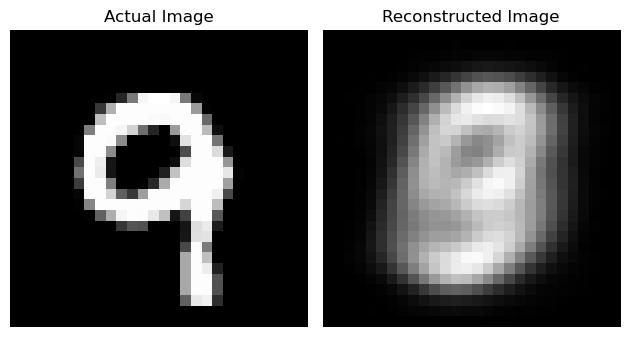

In [10]:
index = 99

encoded_image = trained_VAE.encode(test_images[index])[0]
decoded_image = trained_VAE.decode(encoded_image)

reconstructed_img = decoded_image.reshape(28, 28)
actual_img = test_images[index].reshape(28,28)

# Plot actual vs reconstructed
plt.subplot(1, 2, 1)
plt.imshow(actual_img, cmap='gray')
plt.title("Actual Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()